### GPU Open Analytics Initiative: connect MapD to PyGDF to H2OAIGLM

### In this demo, we will train 4000 regularized linear regression models on the U.S. Census dataset, with the goal to predict the income of a person, given approximately 10000 data points (such as age, occupation, zip code, etc.)

### The dataset is about 2GB in memory (50k rows, 10k cols, single-precision floating-point values), so it fits onto the GPU memory.

### By using multiple GPUs, we are able to speed up this process significantly, and can train about 40 models per second (on a DGX-1 with 8 GPUs)

### Choose to Run or Run+Animate

In [1]:
# run=0: Choose not run h2oaiglm and just pass through all other cells
# run=1: Run h2oaiglm without animation
# Requirements: python3.5
run=1

# anim=0: Don't show animation
# anim=1: Do show animation
# pip install pandas psutil matplotlib --user
# pip install -e git+https://github.com/fbcotter/py3nvml#egg=py3nvml --user
anim=1

PWD = !pwd

In [2]:
import sys
import os.path
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

Add import path to MapD Thrift binding and Arrow schema

In [3]:
thirdparty_path = os.path.join(PWD[0], '..', 'thirdparty')
sys.path.append(thirdparty_path)
thirdparty_path

'/home/jon/h2o4gpu/examples/py/goai/../thirdparty'

If `pygdf` cannot be imported, uncomment code below:

In [4]:
pygdf_path = os.path.join(PWD[0], '..')
sys.path.append(pygdf_path)

In [5]:
import pygdf
import pymapd

In [6]:
dbname = 'mapd'
username = 'mapd'
password = 'HyperInteractive'
hostname = 'localhost'
mport = 9091

con = pymapd.connect(user=username,
                password=password,
                host=hostname,
                dbname=dbname,
                port=mport)

In [7]:
! rm -rf gpuopenai ipums_easy.csv ; git clone git@github.com:h2oai/gpuopenai.git ; cp gpuopenai/pygdf/notebooks/ipums_easy.csv.gz . ; gunzip ipums_easy.csv.gz
import pandas as pd
df = pd.read_csv("ipums_easy.csv")
df

Cloning into 'gpuopenai'...
ssh: /opt/h2oai/dai/python/lib/libcrypto.so.1.0.0: no version information available (required by ssh)
ssh: /opt/h2oai/dai/python/lib/libcrypto.so.1.0.0: no version information available (required by ssh)
remote: Counting objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 8.18 MiB | 5.70 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking connectivity... done.


RECTYPE  YEAR  DATANUM  SERIAL  NUMPREC  SUBSAMP  HHWT  HHTYPE  REPWT  \
0           0  2000        3       1        2       26   600       3    NaN   
1           0  2000        3       1        2       26   600       3    NaN   
2           0  2000        3       2        4       76   600       1    NaN   
3           0  2000        3       2        4       76   600       1    NaN   
4           0  2000        3       2        4       76   600       1    NaN   
5           0  2000        3       2        4       76   600       1    NaN   
6           0  2000        3       3        1        2   600       4    NaN   
7           0  2000        3       4        1       92   600       4    NaN   
8           0  2000        3       5        4       81   600       1    NaN   
9           0  2000        3       5        4       81   600       1    NaN   
10          0  2000        3       5        4       81   600       1    NaN   
11          0  2000        3       5        4       81   600       1    NaN   
12          0  2000        3       6        1        5   600       6    NaN   
13          0  2000        3       7        2        6   600       1    NaN   
14          0  2000        3       7        2        6   600       1    NaN   
15          0  2000        3       8        2        9   600       1    NaN   
16          0  2000        3       8        2        9   600       1    NaN   
17          0  2000        3       9        1       94   400       4    NaN   
18          0  2000        3      10        1       40   600       6    NaN   
19          0  2000        3      11        2       87   600       3    NaN   
20          0  2000        3      11        2       87   600       3    NaN   
21          0  2000        3      12        1       37   200       6    NaN   
22          0  2000        3      13        2       12   600       1    NaN   
23          0  2000        3      13        2       12   600       1    NaN   
24          0  2000        3      14        3       98   600       1    NaN   
25          0  2000        3      14        3       98   600       1    NaN   
26          0  2000        3      14        3       98   600       1    NaN   
27          0  2000        3      15        3       20   150       1    NaN   
28          0  2000        3      15        3       20   150       1    NaN   
29          0  2000        3      15        3       20   150       1    NaN   
...       ...   ...      ...     ...      ...      ...   ...     ...    ...   
9970        0  2000        3    4237        4       95   600       1    NaN   
9971        0  2000        3    4238        2       33   500       1    NaN   
9972        0  2000        3    4238        2       33   500       1    NaN   
9973        0  2000        3    4239        4       38   600       1    NaN   
9974        0  2000        3    4239        4       38   600       1    NaN   
9975        0  2000        3    4239        4       38   600       1    NaN   
9976        0  2000        3    4239        4       38   600       1    NaN   
9977        0  2000        3    4240        2       25   300       1    NaN   
9978        0  2000        3    4240        2       25   300       1    NaN   
9979        0  2000        3    4241        4       42   600       1    NaN   
9980        0  2000        3    4241        4       42   600       1    NaN   
9981        0  2000        3    4241        4       42   600       1    NaN   
9982        0  2000        3    4241        4       42   600       1    NaN   
9983        0  2000        3    4242        1       80   600       6    NaN   
9984        0  2000        3    4243        4       39   600       2    NaN   
9985        0  2000        3    4243        4       39   600       2    NaN   
9986        0  2000        3    4243        4       39   600       2    NaN   
9987        0  2000        3    4243        4       39   600       2    NaN   
9988        0  2000        3    4244        2       43  

In [8]:
table = 'easy_ipums'
_create = '''CREATE TABLE {}(RECTYPE INTEGER,
IPUMS_YEAR INTEGER,
DATANUM INTEGER,
SERIAL INTEGER,
NUMPREC INTEGER,
SUBSAMP INTEGER,
HHWT INTEGER,
HHTYPE INTEGER,
REPWT DOUBLE,
CLUSTER DOUBLE,
ADJUST DOUBLE,
CPI99 DOUBLE,
REGION INTEGER,
STATEICP INTEGER,
STATEFIP INTEGER,
COUNTY DOUBLE,
COUNTYFIPS DOUBLE,
METRO DOUBLE,
METAREA DOUBLE,
METAREAD DOUBLE,
MET2013 DOUBLE,
MET2013ERR DOUBLE,
CITY DOUBLE,
CITYERR DOUBLE,
CITYPOP DOUBLE,
PUMA DOUBLE,
PUMARES2MIG DOUBLE,
STRATA INTEGER,
PUMASUPR DOUBLE,
CONSPUMA DOUBLE,
CPUMA0010 DOUBLE,
APPAL DOUBLE,
APPALD DOUBLE,
HOMELAND DOUBLE,
MET2003 DOUBLE,
CNTRY INTEGER,
GQ INTEGER,
GQTYPE INTEGER,
GQTYPED INTEGER,
FARM INTEGER,
OWNERSHP INTEGER,
OWNERSHPD INTEGER,
MORTGAGE INTEGER,
MORTGAG2 INTEGER,
COMMUSE INTEGER,
FARMPROD INTEGER,
ACREHOUS INTEGER,
MORTAMT1 INTEGER,
MORTAMT2 INTEGER,
TAXINCL INTEGER,
INSINCL INTEGER,
PROPINSR INTEGER,
PROPTX99 INTEGER,
OWNCOST INTEGER,
RENT INTEGER,
RENTGRS INTEGER,
RENTMEAL INTEGER,
CONDOFEE INTEGER,
MOBLHOME DOUBLE,
MOBLHOM2 INTEGER,
MOBLOAN INTEGER,
SECRES DOUBLE,
SECRESMO DOUBLE,
SECRESRE DOUBLE,
COSTELEC INTEGER,
COSTGAS INTEGER,
COSTWATR INTEGER,
COSTFUEL INTEGER,
HHINCOME INTEGER,
PUBHOUS INTEGER,
RENTSUB INTEGER,
HEATSUB INTEGER,
LUNCHSUB INTEGER,
FOODSTMP INTEGER,
FDSTPAMT DOUBLE,
VALUEH INTEGER,
LINGISOL INTEGER,
VACANCY INTEGER,
KITCHEN INTEGER,
KITCHENORIG DOUBLE,
FRIDGE DOUBLE,
FRIDGEORIG DOUBLE,
SINK DOUBLE,
STOVE DOUBLE,
ROOMS INTEGER,
ROOMSORIG DOUBLE,
PLUMBING INTEGER,
HOTWATER DOUBLE,
SHOWER DOUBLE,
TOILET DOUBLE,
BUILTYR INTEGER,
BUILTYR2 INTEGER,
UNITSSTR INTEGER,
BEDROOMS INTEGER,
BEDROOMSORIG DOUBLE,
PHONE INTEGER,
PHONEORIG DOUBLE,
CILAPTOP DOUBLE,
CIHAND DOUBLE,
CIOTHCOMP DOUBLE,
CINETHH DOUBLE,
CIMODEM DOUBLE,
CISAT DOUBLE,
CIDSL DOUBLE,
CIFIBER DOUBLE,
CIBRDBND DOUBLE,
CIDIAL DOUBLE,
CIOTHSVC DOUBLE,
FUELHEAT INTEGER,
VEHICLES INTEGER,
SSMC DOUBLE,
NFAMS INTEGER,
NSUBFAM INTEGER,
NCOUPLES INTEGER,
NMOTHERS INTEGER,
NFATHERS INTEGER,
MULTGEN INTEGER,
MULTGEND INTEGER,
CBNSUBFAM INTEGER,
REPWT1 DOUBLE,
REPWT2 DOUBLE,
REPWT3 DOUBLE,
REPWT4 DOUBLE,
REPWT5 DOUBLE,
REPWT6 DOUBLE,
REPWT7 DOUBLE,
REPWT8 DOUBLE,
REPWT9 DOUBLE,
REPWT10 DOUBLE,
REPWT11 DOUBLE,
REPWT12 DOUBLE,
REPWT13 DOUBLE,
REPWT14 DOUBLE,
REPWT15 DOUBLE,
REPWT16 DOUBLE,
REPWT17 DOUBLE,
REPWT18 DOUBLE,
REPWT19 DOUBLE,
REPWT20 DOUBLE,
REPWT21 DOUBLE,
REPWT22 DOUBLE,
REPWT23 DOUBLE,
REPWT24 DOUBLE,
REPWT25 DOUBLE,
REPWT26 DOUBLE,
REPWT27 DOUBLE,
REPWT28 DOUBLE,
REPWT29 DOUBLE,
REPWT30 DOUBLE,
REPWT31 DOUBLE,
REPWT32 DOUBLE,
REPWT33 DOUBLE,
REPWT34 DOUBLE,
REPWT35 DOUBLE,
REPWT36 DOUBLE,
REPWT37 DOUBLE,
REPWT38 DOUBLE,
REPWT39 DOUBLE,
REPWT40 DOUBLE,
REPWT41 DOUBLE,
REPWT42 DOUBLE,
REPWT43 DOUBLE,
REPWT44 DOUBLE,
REPWT45 DOUBLE,
REPWT46 DOUBLE,
REPWT47 DOUBLE,
REPWT48 DOUBLE,
REPWT49 DOUBLE,
REPWT50 DOUBLE,
REPWT51 DOUBLE,
REPWT52 DOUBLE,
REPWT53 DOUBLE,
REPWT54 DOUBLE,
REPWT55 DOUBLE,
REPWT56 DOUBLE,
REPWT57 DOUBLE,
REPWT58 DOUBLE,
REPWT59 DOUBLE,
REPWT60 DOUBLE,
REPWT61 DOUBLE,
REPWT62 DOUBLE,
REPWT63 DOUBLE,
REPWT64 DOUBLE,
REPWT65 DOUBLE,
REPWT66 DOUBLE,
REPWT67 DOUBLE,
REPWT68 DOUBLE,
REPWT69 DOUBLE,
REPWT70 DOUBLE,
REPWT71 DOUBLE,
REPWT72 DOUBLE,
REPWT73 DOUBLE,
REPWT74 DOUBLE,
REPWT75 DOUBLE,
REPWT76 DOUBLE,
REPWT77 DOUBLE,
REPWT78 DOUBLE,
REPWT79 DOUBLE,
REPWT80 DOUBLE,
RESPMODE DOUBLE,
PERNUM INTEGER,
PERWT INTEGER,
SLWT INTEGER,
REPWTP DOUBLE,
FAMSIZE INTEGER,
NCHILD INTEGER,
NCHLT5 INTEGER,
FAMUNIT INTEGER,
ELDCH INTEGER,
YNGCH INTEGER,
NSIBS INTEGER,
MOMLOC INTEGER,
STEPMOM INTEGER,
MOMRULE INTEGER,
POPLOC INTEGER,
STEPPOP INTEGER,
POPRULE INTEGER,
SPLOC INTEGER,
SPRULE INTEGER,
SUBFAM INTEGER,
SFTYPE INTEGER,
SFRELATE INTEGER,
CBSUBFAM INTEGER,
CBSFTYPE INTEGER,
CBSFRELATE INTEGER,
RELATE INTEGER,
RELATED INTEGER,
SEX INTEGER,
AGE INTEGER,
AGEORIG DOUBLE,
BIRTHQTR DOUBLE,
MARST INTEGER,
BIRTHYR INTEGER,
MARRNO DOUBLE,
MARRINYR DOUBLE,
YRMARR DOUBLE,
DIVINYR DOUBLE,
WIDINYR DOUBLE,
FERTYR INTEGER,
RACE INTEGER,
RACED INTEGER,
HISPAN INTEGER,
HISPAND INTEGER,
BPL INTEGER,
BPLD INTEGER,
ANCESTR1 INTEGER,
ANCESTR1D INTEGER,
ANCESTR2 INTEGER,
ANCESTR2D INTEGER,
CITIZEN INTEGER,
YRNATUR DOUBLE,
YRIMMIG INTEGER,
YRSUSA1 INTEGER,
YRSUSA2 INTEGER,
SPOKEN_LANGUAGE INTEGER,
LANGUAGED INTEGER,
SPEAKENG INTEGER,
TRIBE INTEGER,
TRIBED INTEGER,
RACESING INTEGER,
RACESINGD INTEGER,
RACAMIND INTEGER,
RACASIAN INTEGER,
RACBLK INTEGER,
RACPACIS INTEGER,
RACWHT INTEGER,
RACOTHER INTEGER,
RACNUM INTEGER,
SCHOOL INTEGER,
EDUC INTEGER,
EDUCD INTEGER,
GRADEATT INTEGER,
GRADEATTD INTEGER,
SCHLTYPE INTEGER,
DEGFIELD DOUBLE,
DEGFIELDD DOUBLE,
DEGFIELD2 DOUBLE,
DEGFIELD2D DOUBLE,
EMPSTAT INTEGER,
EMPSTATD INTEGER,
LABFORCE INTEGER,
OCC INTEGER,
OCC1950 INTEGER,
OCC1990 INTEGER,
OCC2010 INTEGER,
IND INTEGER,
IND1950 INTEGER,
IND1990 INTEGER,
CLASSWKR INTEGER,
CLASSWKRD INTEGER,
OCCSOC INTEGER,
INDNAICS INTEGER,
WKSWORK1 INTEGER,
WKSWORK2 INTEGER,
UHRSWORK INTEGER,
WRKLSTWK INTEGER,
ABSENT INTEGER,
LOOKING INTEGER,
AVAILBLE INTEGER,
WRKRECAL INTEGER,
WORKEDYR INTEGER,
INCTOT INTEGER,
FTOTINC INTEGER,
INCWAGE INTEGER,
INCBUS00 INTEGER,
INCSS INTEGER,
INCWELFR INTEGER,
INCINVST INTEGER,
INCRETIR INTEGER,
INCSUPP INTEGER,
INCOTHER INTEGER,
INCEARN INTEGER,
POVERTY INTEGER,
OCCSCORE INTEGER,
SEI INTEGER,
HWSEI DOUBLE,
PRESGL DOUBLE,
PRENT DOUBLE,
ERSCOR50 DOUBLE,
ERSCOR90 DOUBLE,
EDSCOR50 DOUBLE,
EDSCOR90 DOUBLE,
NPBOSS50 DOUBLE,
NPBOSS90 DOUBLE,
MIGRATE1 INTEGER,
MIGRATE1D INTEGER,
MIGPLAC1 INTEGER,
MIGMET1 DOUBLE,
MIGTYPE1 DOUBLE,
MIGCITY1 DOUBLE,
MIGPUMS1 DOUBLE,
MIGPUMA1 DOUBLE,
MOVEDIN INTEGER,
MOVEDINORIG DOUBLE,
DISABWRK INTEGER,
VETDISAB DOUBLE,
DIFFREM INTEGER,
DIFFPHYS INTEGER,
DIFFMOB INTEGER,
DIFFCARE INTEGER,
DIFFSENS INTEGER,
DIFFEYE DOUBLE,
DIFFHEAR DOUBLE,
VETSTAT INTEGER,
VETSTATD INTEGER,
VET01LTR DOUBLE,
VET95X00 INTEGER,
VET90X01 DOUBLE,
VET90X95 INTEGER,
VET75X90 INTEGER,
VET80X90 INTEGER,
VET75X80 INTEGER,
VETVIETN INTEGER,
VET55X64 INTEGER,
VETKOREA INTEGER,
VET47X50 DOUBLE,
VETWWII INTEGER,
VETOTHER INTEGER,
VETYRS INTEGER,
PWSTATE2 INTEGER,
PWMETRO DOUBLE,
PWCITY DOUBLE,
PWTYPE DOUBLE,
PWPUMA00 DOUBLE,
PWPUMAS DOUBLE,
TRANWORK INTEGER,
CARPOOL INTEGER,
RIDERS INTEGER,
TRANTIME INTEGER,
DEPARTS INTEGER,
ARRIVES DOUBLE,
GCHOUSE INTEGER,
GCMONTHS INTEGER,
GCRESPON INTEGER,
PROBAI INTEGER,
PROBAPI INTEGER,
PROBBLK INTEGER,
PROBOTH INTEGER,
PROBWHT INTEGER,
REPWTP1 DOUBLE,
REPWTP2 DOUBLE,
REPWTP3 DOUBLE,
REPWTP4 DOUBLE,
REPWTP5 DOUBLE,
REPWTP6 DOUBLE,
REPWTP7 DOUBLE,
REPWTP8 DOUBLE,
REPWTP9 DOUBLE,
REPWTP10 DOUBLE,
REPWTP11 DOUBLE,
REPWTP12 DOUBLE,
REPWTP13 DOUBLE,
REPWTP14 DOUBLE,
REPWTP15 DOUBLE,
REPWTP16 DOUBLE,
REPWTP17 DOUBLE,
REPWTP18 DOUBLE,
REPWTP19 DOUBLE,
REPWTP20 DOUBLE,
REPWTP21 DOUBLE,
REPWTP22 DOUBLE,
REPWTP23 DOUBLE,
REPWTP24 DOUBLE,
REPWTP25 DOUBLE,
REPWTP26 DOUBLE,
REPWTP27 DOUBLE,
REPWTP28 DOUBLE,
REPWTP29 DOUBLE,
REPWTP30 DOUBLE,
REPWTP31 DOUBLE,
REPWTP32 DOUBLE,
REPWTP33 DOUBLE,
REPWTP34 DOUBLE,
REPWTP35 DOUBLE,
REPWTP36 DOUBLE,
REPWTP37 DOUBLE,
REPWTP38 DOUBLE,
REPWTP39 DOUBLE,
REPWTP40 DOUBLE,
REPWTP41 DOUBLE,
REPWTP42 DOUBLE,
REPWTP43 DOUBLE,
REPWTP44 DOUBLE,
REPWTP45 DOUBLE,
REPWTP46 DOUBLE,
REPWTP47 DOUBLE,
REPWTP48 DOUBLE,
REPWTP49 DOUBLE,
REPWTP50 DOUBLE,
REPWTP51 DOUBLE,
REPWTP52 DOUBLE,
REPWTP53 DOUBLE,
REPWTP54 DOUBLE,
REPWTP55 DOUBLE,
REPWTP56 DOUBLE,
REPWTP57 DOUBLE,
REPWTP58 DOUBLE,
REPWTP59 DOUBLE,
REPWTP60 DOUBLE,
REPWTP61 DOUBLE,
REPWTP62 DOUBLE,
REPWTP63 DOUBLE,
REPWTP64 DOUBLE,
REPWTP65 DOUBLE,
REPWTP66 DOUBLE,
REPWTP67 DOUBLE,
REPWTP68 DOUBLE,
REPWTP69 DOUBLE,
REPWTP70 DOUBLE,
REPWTP71 DOUBLE,
REPWTP72 DOUBLE,
REPWTP73 DOUBLE,
REPWTP74 DOUBLE,
REPWTP75 DOUBLE,
REPWTP76 DOUBLE,
REPWTP77 DOUBLE,
REPWTP78 DOUBLE,
REPWTP79 DOUBLE,
REPWTP80 DOUBLE)'''.format(table)
_drop = '''DROP TABLE IF EXISTS {}'''.format(table)
con.execute(_drop)
con.execute(_create)
# load data
con.load_table(table, df.itertuples(index=False))

## MapD to Pygdf

In [9]:
sourceDev=0
query = '''Select * from {}'''.format(table)
df = con.select_ipc_gpu(query,device_id=sourceDev)
df.head(5)

  RECTYPE IPUMS_YEAR DATANUM SERIAL NUMPREC SUBSAMP HHWT HHTYPE REPWT         CLUSTER   ADJUST CPI99 REGION STATEICP STATEFIP COUNTY COUNTYFIPS METRO METAREA METAREAD MET2013 MET2013ERR CITY CITYERR CITYPOP PUMA PUMARES2MIG STRATA PUMASUPR CONSPUMA CPUMA0010 APPAL APPALD HOMELAND MET2003 CNTRY   GQ GQTYPE GQTYPED FARM OWNERSHP OWNERSHPD MORTGAGE MORTGAG2 COMMUSE FARMPROD ACREHOUS MORTAMT1 MORTAMT2 TAXINCL INSINCL PROPINSR PROPTX99 OWNCOST RENT RENTGRS RENTMEAL CONDOFEE MOBLHOME MOBLHOM2 MOBLOAN SECRES SECRESMO SECRESRE COSTELEC COSTGAS COSTWATR COSTFUEL HHINCOME PUBHOUS RENTSUB HEATSUB LUNCHSUB FOODSTMP FDSTPAMT VALUEH LINGISOL VACANCY KITCHEN KITCHENORIG FRIDGE FRIDGEORIG SINK STOVE ROOMS ROOMSORIG PLUMBING HOTWATER SHOWER TOILET BUILTYR BUILTYR2 UNITSSTR BEDROOMS BEDROOMSORIG PHONE PHONEORIG CILAPTOP CIHAND CIOTHCOMP CINETHH CIMODEM CISAT CIDSL CIFIBER CIBRDBND CIDIAL CIOTHSVC FUELHEAT VEHICLES SSMC NFAMS NSUBFAM NCOUPLES NMOTHERS NFATHERS MULTGEN MULTGEND CBNSUBFAM REPWT1 REPWT2 REP

In [10]:
df['INCEARN'].mean()

18298.2888

Preprocess the data

In [11]:
num_cols = set()
cat_cols = set()
response_set = set(['INCEARN'])
feature_names = set(df.columns) - response_set

Determine categorical and numeric columns.  Compute unique values from categorical columns.

In [12]:
uniques = {}
for k in feature_names:
    try:
        uniquevals = df[k].unique_k(k=1000)
        uniques[k] = uniquevals
    except ValueError:
        # more than 1000 unique values
        num_cols.add(k)
    else:
        # within 1000 unique values
        nunique = len(uniquevals)
        if nunique < 2:
            del df[k]        # drop constant column
        elif 1 < nunique < 1000:
            cat_cols.add(k)  # as cat column
        else:
            num_cols.add(k)  # as num column

Fix numeric columns.  Fill NA, Scale to [0, 1]. Drop near constant

In [13]:
import numpy as np
for k in (num_cols - response_set):
    df[k] = df[k].fillna(df[k].mean())
    assert df[k].null_count == 0
    std = df[k].std()
    # drop near constant columns
    if not np.isfinite(std) or std < 1e-4:
        del df[k]
        print('drop near constant', k)
    else:
        df[k] = df[k].scale()

drop near constant CLUSTER


Expand categorical columns

In [14]:
for k in cat_cols:
    cats = uniques[k][1:]  # drop first
    df = df.one_hot_encoding(k, prefix=k, cats=cats)
    del df[k]

Ensure INCEARN is float64

In [15]:
nrows=len(df)
print(nrows)
df['intercept'] = np.ones(nrows, dtype=np.float64)

10000


In [16]:
df['INCEARN'] = df['INCEARN'].astype(np.float64)

In [17]:
# Print dtypes
{df[k].dtype for k in df.columns}

{dtype('float64')}

Create 60-40: training - testing

In [18]:
# Fraction for train (test is 1-FRACTION)
FRACTION=0.8
validFraction=1.0-FRACTION
n60 = int(len(df) * FRACTION)
print('60% of {} is {}'.format(len(df), n60))
train_df = df.loc[:n60]
if FRACTION<1.0:
    test_df = df.loc[n60:]
    print('train_df has {} rows | test_df has {} rows'.format(len(train_df), len(test_df)))
else:
    print('train_df has {} rows | test_df has {} rows'.format(len(train_df), 0))

60% of 10000 is 8000
train_df has 8001 rows | test_df has 2000 rows


Turn the dataframes into a matrix

In [19]:
train_data_mat = train_df.as_gpu_matrix(columns=df.columns[1:])
train_result_mat = train_df.as_gpu_matrix(columns=[df.columns[0]])
if FRACTION<1.0:
    test_data_mat = test_df.as_gpu_matrix(columns=df.columns[1:])
    test_result_mat = test_df.as_gpu_matrix(columns=[df.columns[0]])

In [20]:
#print(train_df.as_matrix(columns=[df.columns[0]]))

In [21]:
print(train_df['INCEARN'].mean())
if FRACTION<1.0:
    print(test_df['INCEARN'].mean())

18382.344831896015
17990.3735


In [22]:
print(train_data_mat.shape)
print(train_result_mat.shape)
if FRACTION<1.0:
    print(test_data_mat.shape)
    print(test_result_mat.shape)

(8001, 10818)
(8001, 1)
(2000, 10818)
(2000, 1)


Cleanup the IPC handle.

Note: `.as_gpu_matrix()` has created new copies; thus, we can close the IPC handle.

In [23]:
#ipch.close()

The ctypes pointer to the gpu matrices

In [24]:
train_data_mat_ptr = train_data_mat.device_ctypes_pointer
train_result_mat_ptr = train_result_mat.device_ctypes_pointer
print('train_data_mat_ptr address', hex(train_data_mat_ptr.value))
print('train_result_mat_ptr address', hex(train_result_mat_ptr.value))
if FRACTION<1.0:
    test_data_mat_ptr = test_data_mat.device_ctypes_pointer
    test_result_mat_ptr = test_result_mat.device_ctypes_pointer
    print('test_data_mat_ptr address', hex(test_data_mat_ptr.value))
    print('test_result_mat_ptr address', hex(test_result_mat_ptr.value))

train_data_mat_ptr address 0x7f664a000000
train_result_mat_ptr address 0x7f66b7600000
test_data_mat_ptr address 0x7f663e000000
test_result_mat_ptr address 0x7f66b7c13400


In [25]:
import os
os.getcwd()

'/home/jon/h2o4gpu/examples/py/goai'

### Import H2OAIGLM

In [26]:
# Load H2OAIGLM
import h2o4gpu as h2o4gpu
from ctypes import *
import time
if anim==1:
    import pandas as pd

a=c_void_p(train_data_mat_ptr.value)
b=c_void_p(train_result_mat_ptr.value)
if FRACTION<1.0:
    c=c_void_p(test_data_mat_ptr.value)
    d=c_void_p(test_result_mat_ptr.value)
else:
    c=c_void_p(0)
    d=c_void_p(0)

### Define some helper methods for plotting and running the algorithm

In [27]:
def new_alpha(row_fold):
    if row_fold == 0:
        return -0.025
    elif row_fold == 1:
        return -0.05
    elif row_fold == 3:
        return 0.025
    elif row_fold == 4:
        return 0.05
    else: return 0

def plot_cpu_perf(axis, cpu_labels, cpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(cpu_labels, cpu_snapshot, color='dodgerblue')
    axis.set_title('CPU Utilization', fontsize = 16)
    
def plot_gpu_perf(axis, gpu_labels, gpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_xticks(gpu_labels)
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(gpu_labels, gpu_snapshot, width =0.5, color = 'limegreen')
    axis.set_title('GPU Utilization', fontsize = 16)
    
def plot_glm_results(axis, results, best_rmse, cb):
    axis.cla()
    axis.set_xscale('log')
    axis.set_xlim([0.1, 1e9])
    axis.set_ylim([-0.12, 1.12])
    axis.set_yticks([x/7. for x in range(0,8)])
    axis.set_ylabel('Parameter 1:  '+r'$\alpha$', fontsize = 16)
    axis.set_xlabel('Parameter 2:  '+r'$\lambda$', fontsize = 16)
    num_models = min(4000,int(4000*results.shape[0]/2570))
    axis.set_title('Elastic Net Models Trained and Evaluated: ' + str(num_models), fontsize = 16)

    try:
        cm = ListedColormap(sns.color_palette("RdYlGn", 10).as_hex())
        cf = axis.scatter(results['lambda'], results['alpha_prime'], c=results['rel_acc'], 
                    cmap=cm, vmin=0, vmax=1)
        axis.plot(best_rmse['lambda'],best_rmse['alpha_prime'], 'o',
            ms=15, mec='k', mfc='none', mew=2)

        if not cb:
            cb = pl.colorbar(cf, ax=axis)
            cb.set_label('Relative  Validation  Accuracy', rotation=270, 
                         labelpad=18, fontsize = 16)   
        cb.update_normal(cf)
    except:
        #print("plot_glm_results exception -- no frame")
        pass

from py3nvml.py3nvml import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")
import psutil
import numpy as np
import pylab as pl
from IPython import display
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import sys
import subprocess
maxNGPUS = int(subprocess.check_output("nvidia-smi -L | wc -l", shell=True))
print("Maximum Number of GPUS:", maxNGPUS)

nvmlInit()
deviceCount = nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvmlDeviceGetHandleByIndex(i)
    #print("Device {}: {}".format(i, nvmlDeviceGetName(handle)))
    #print ("Driver Version:", nvmlSystemGetDriverVersion())

import os
def RunAnimation(arg):
    deviceCount = arg
    file = os.getcwd() + "/rmse.txt"
    fig = pl.figure(figsize = (9,9))
    pl.rcParams['xtick.labelsize'] = 14
    pl.rcParams['ytick.labelsize'] = 14
    gs = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.4)
    ax1 = pl.subplot(gs[0,-2])
    ax2 = pl.subplot(gs[0,1])
    ax3 = pl.subplot(gs[1:,:])
    fig.suptitle('H2O.ai Machine Learning $-$ Generalized Linear Modeling', size=18)

    pl.gcf().subplots_adjust(bottom=0.2)

    cb = False
    os.system("mkdir -p images")
    i=0
    while(True):
        try:
            #cpu
            snapshot = psutil.cpu_percent(percpu=True)
            cpu_labels = range(1,len(snapshot)+1)
            plot_cpu_perf(ax1, cpu_labels, snapshot)
    
            #gpu
            gpu_snapshot = []
            gpu_labels = list(range(1,deviceCount+1))
            for j in range(deviceCount):
                handle = nvmlDeviceGetHandleByIndex(j)
                util = nvmlDeviceGetUtilizationRates(handle)
                gpu_snapshot.append(util.gpu)
            gpu_snapshot = gpu_snapshot   
            plot_gpu_perf(ax2, gpu_labels, gpu_snapshot)
    
            res = pd.read_csv(file, sep="\s+",header=None,names=['time','pass','fold','a','i','alpha','lambda','trainrmse','ivalidrmse','validrmse'])
            
            res['rel_acc'] = ((38000- res['validrmse'])/(38000-28000))
            res['alpha_prime'] = res['alpha'] + res['fold'].apply(lambda x: new_alpha(x))

            best = res.ix[res['rel_acc']==np.max(res['rel_acc']),:]
            plot_glm_results(ax3, res, best.tail(1), cb)
            # flag for colorbar to avoid redrawing
            cb = True

            # Add footnotes
            footnote_text = "*U.S. Census dataset (predict Income): 45k rows, 10k cols\nParameters: 5-fold cross-validation, " + r'$\alpha = \{\frac{i}{7},i=0\ldots7\}$' + ", "\
   'full $\lambda$-' + "search"
            #pl.figtext(.05, -.04, footnote_text, fontsize = 14,)
            pl.annotate(footnote_text, (0,0), (-30, -50), fontsize = 12,
                        xycoords='axes fraction', textcoords='offset points', va='top')

            #update the graphics
            display.display(pl.gcf())
            display.clear_output(wait=True)
            time.sleep(0.01)

            #save the images
            saveimage=0
            if saveimage:
                file_name = './images/glm_run_%04d.png' % (i,)
                pl.savefig(file_name, dpi=200)
            i=i+1
        
        except KeyboardInterrupt:
            break
        #except:
        #    #print("Could not Create Frame")
        #    pass

Maximum Number of GPUS: 2


### Choose Data Size and Order and How was processed for H2OAIGLM

In [28]:
intercept = 1 #
n=train_data_mat.shape[1]
mTrain=train_data_mat.shape[0]
if FRACTION<1.0:
    mValid=test_data_mat.shape[0]
else:
    mValid=0
print("n=%d mTrain=%d mValid=%d" % (n,mTrain,mValid))
# Order of data
fortran = 1
print("fortran=%d" % (fortran))
result={df[k].dtype for k in df.columns}
print(result)
print(fortran)
if result.pop() == np.dtype('float64'):
    print("double precision")
    precision=1
else:
    print("single precision")
    precision=0

n=10818 mTrain=8001 mValid=2000
fortran=1
{dtype('float64')}
1
double precision


### Help function to use Mapd->pygdf data pointers in GPU on H2OAIGLM

In [32]:
help(h2o4gpu.ElasticNetH2O.)

Help on class ElasticNetH2O in module h2o4gpu.solvers.elastic_net:

class ElasticNetH2O(builtins.object)
 |  H2O Elastic Net Solver for GPUs
 |  
 |  Parameters
 |  ----------
 |  n_threads : int, (Default=None)
 |      Number of threads to use in the gpu.
 |      Each thread is an independent model builder.
 |  
 |  gpu_id : int, optional, (default=0)
 |      ID of the GPU on which the algorithm should run.
 |  
 |  n_gpus : int, (Default=-1)
 |      Number of gpu's to use in GLM solver.
 |  
 |  order : string, (Default='r')
 |      Row or Column major for C/C++ backend. Default is 'r'.
 |      Must be 'r' (Row major) or 'c' (Column major).
 |  
 |  fit_intercept : bool, (default=True)
 |      Include constant term in the model.
 |  
 |  lambda_min_ratio: float, (Default=1E-7).
 |      Minimum lambda ratio to maximum lambda, used
 |      in lambda search.
 |  
 |  n_lambdas : int, (Default=100)
 |      Number of lambdas to be used in a search.
 |  
 |  n_folds : int,  (Default=1)
 | 

In [30]:
def RunH2Oaiglm(arg):
    intercept, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs = arg
    order='c' if fortran else 'r'
        
    #print("Setting up Solver")
    os.system("rm -f rmse.txt ; touch rmse.txt ; rm -f varimp.txt ; touch varimp.txt")
    model = h2o4gpu.ElasticNetH2O(n_gpus=nGPUs, order=order, fit_intercept=intercept, lambda_min_ratio=lambda_min_ratio, n_lambdas=nLambdas, n_folds=nFolds, n_alphas=nAlphas)

    # Not using weights
    e=c_void_p(0)

    print("Solving")
    ## Solve
    t0 = time.time()
    print("vars: %d %d %d %d %d %d" % (sourceDev, mTrain, n, mValid, intercept, precision))
    model.fit_ptr(mTrain, n, mValid, precision, order, a, b, c, d, e, source_dev=sourceDev)
    t1 = time.time()
    print("Done Solving")
    print("Time to train H2O AI GLM: %r" % (t1-t0))

### Train 4000 Elastic Net Models (5-fold cross-validation, 8 $\alpha$ values, 100 $\lambda$ values)

In [31]:
lambda_min_ratio=1E-9
nFolds=5
nAlphas=8
nLambdas=100
nGPUs=maxNGPUS # choose all GPUs


if run==1 and anim==0:
    # Run Model
    arg = intercept, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs 
    RunH2Oaiglm(arg)

if run==1 and anim==1:
    from threading import Thread

    # Run Model
    arg = intercept, lambda_min_ratio, nFolds, nAlphas, nLambdas, nGPUs 
    background_thread = Thread(target=RunH2Oaiglm, args=(arg,))
    background_thread.start()

Solving
vars: 0 8001 10818 2000 1 1


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/h2oai/dai/python/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/h2oai/dai/python/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-30-2015cfccf5e4>", line 16, in RunH2Oaiglm
    model.fit_ptr(mTrain, n, mValid, precision, order, a, b, c, d, e, source_dev=sourceDev)
  File "/opt/h2oai/dai/cuda-9.0/lib/python3.6/site-packages/h2o4gpu/solvers/elastic_net.py", line 479, in fit_ptr
    free_input_data=free_input_data)
  File "/opt/h2oai/dai/cuda-9.0/lib/python3.6/site-packages/h2o4gpu/solvers/elastic_net.py", line 665, in _fitorpredict_ptr
    count_more
TypeError: in method 'elastic_net_ptr_double', argument 32 of type 'double *'



![ScreenShot](gtc-2017-anaconda_v3_key.png)

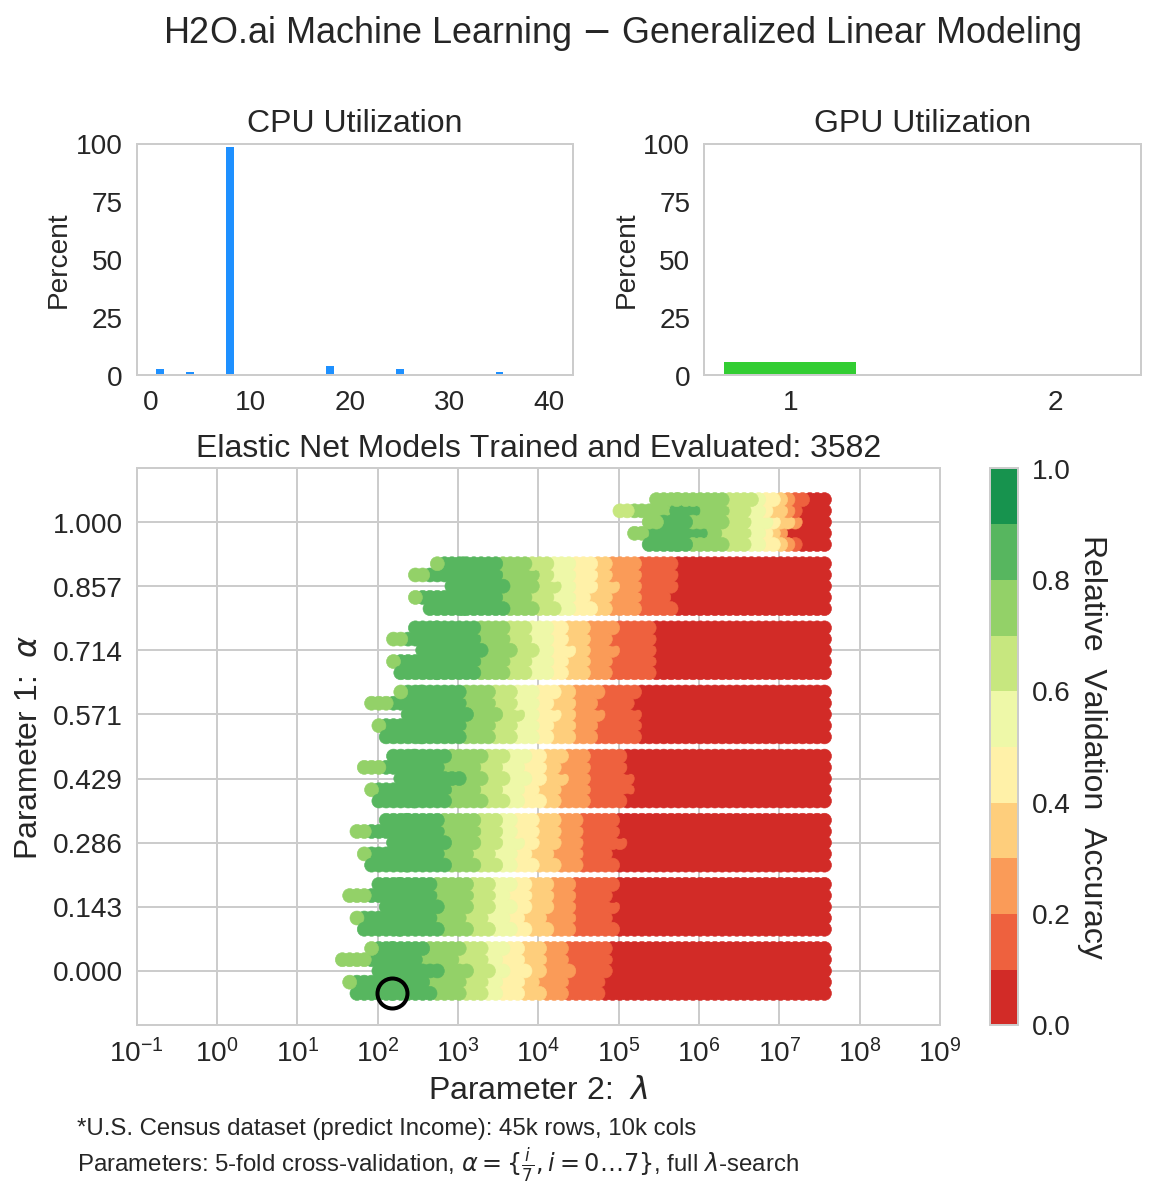

In [ ]:
if run==1 and anim==1:
    # Show Animation
    arg = nGPUs
    RunAnimation(arg)